In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Group Assignement
### CNN  with :

- **Flowers Dataset**


In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


# New
from torchsummary import summary
from torchvision import datasets, transforms

import tensorflow as tf 
%matplotlib inline

2023-12-06 11:25:20.827588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
###----------------
### Some parameters
###----------------

inpDir = '/home/dai/Documents/DNN/7.DNN/input'
outDir = '../output'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 150 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32

# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188


# for early stopping 
LR_PATIENCE = 10
LR_FACTOR = 0.5
PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

#### Read Flowers Dataset

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)

data_dir = pathlib.Path(data_dir)

In [5]:
data_dir

PosixPath('/home/dai/.keras/datasets/flower_photos')

In [6]:
###----------------
### Transformation
###----------------

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize( mean= [0.485, 0.456, 0.406],
                         std = [0.229, 0.244, 0.225])
    ])


dataset = datasets.ImageFolder(data_dir, transform = transform)

In [5]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [6]:
dataset_size = len(dataset)

test_size = int(TEST_SIZE * dataset_size) # 22*32

print(dataset_size, test_size)

3670 734


In [7]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up test_size
train_dataset = torch.utils.data.Subset(dataset, indices[:-test_size])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset, indices[-test_size:])

In [8]:
class_names = train_dataset.dataset.classes

class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [9]:
numClasses = len(class_names)
numClasses

5

In [10]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

### Data Loader

In [11]:

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True)

trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print(trainSteps, testSteps)

91 22


In [12]:
def fn_showImages(img, ax):
    
    img = img.numpy().transpose((1, 2, 0))
    
    means= np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.244, 0.225])
    img = stds * img + means
    img = np.clip(img, 0, 1)
    ax.imshow(img)    
    

torch.Size([32, 3, 188, 188]) torch.Size([32])


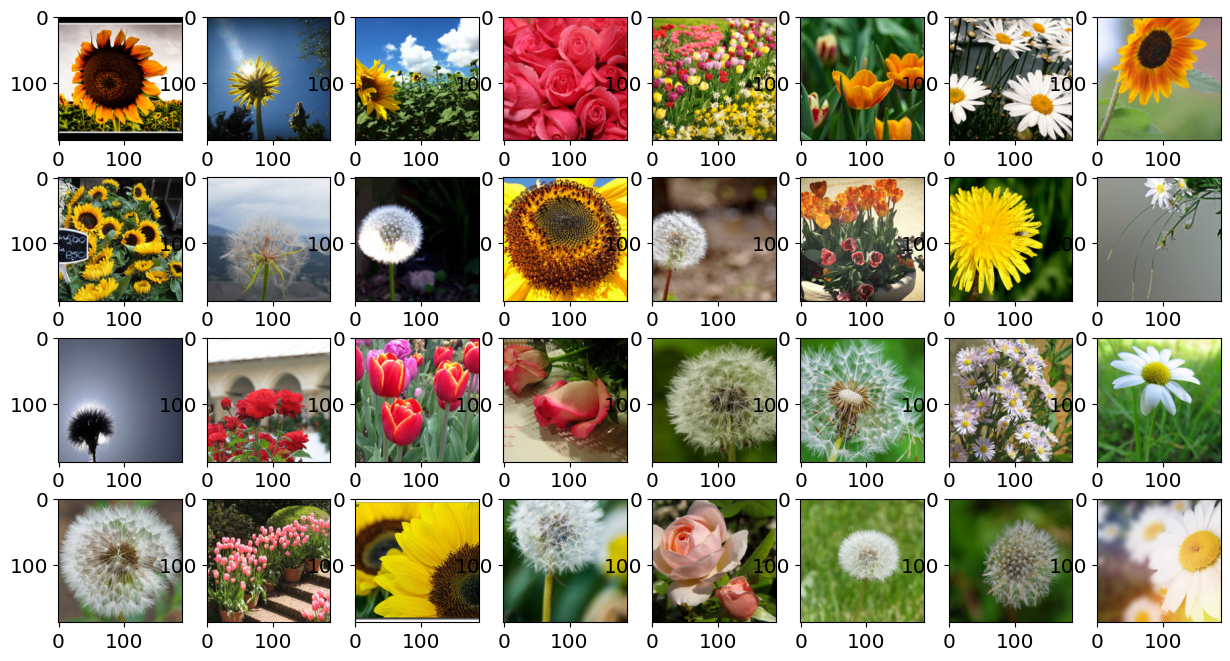

In [13]:
images, labels = next(iter(train_dataloader))

print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    fn_showImages(images[i], ax)


### CNN Model

In [14]:
torch.version.cuda

'12.1'

In [15]:
#torch.cuda.current_device()

In [16]:
#torch.cuda.get_device_name(torch.cuda.current_device())

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
outChannels1 = 64
outChannels2 = 128
outChannels3 = 256
outChannels4 = 512
outChannels5 = 512
outChannels6 = 1024

NumChannels = 3 # Hard coded


model = nn.Sequential(
    
    ### Set 1
    nn.Conv2d(in_channels=NumChannels, out_channels=outChannels1,
              kernel_size = (3, 3),
              padding= 'same'), # 188 * 188 * 64
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2, 2), stride= (2, 2)), # 94 * 94 * 64
    
    ### Set 2
    nn.Conv2d(in_channels=outChannels1, out_channels=outChannels2,
              kernel_size = (3, 3),
              padding= 'same'), # 92 * 92 * 238
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2, 2), stride= (2, 2)), # 46 * 46 * 128
    
    ### Set 3
    nn.Conv2d(in_channels=outChannels2, out_channels=outChannels3,
              kernel_size = (3, 3)), # 44 * 44 * 256
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2, 2), stride= (2, 2)), # 22 * 22 * 256
    
    ### Set 4
    nn.Conv2d(in_channels=outChannels3, out_channels=outChannels4,
              kernel_size = (3, 3)), # 20 * 20 * 512
    #nn.Batch.Norm2d(outChannels4)
    nn.ReLU(),
    #nn.Dropout(drop_out_rate)
    nn.MaxPool2d(kernel_size = (2, 2), stride= (2, 2)), # 10 * 10 * 512
    
    ### Set 5
    nn.Conv2d(in_channels=outChannels4, out_channels=outChannels5,
              kernel_size = (3, 3)), # 8 * 8 * 512
    nn.ReLU(),
    
    
    nn.MaxPool2d(kernel_size = (2, 2), stride= (2, 2)), # 4 * 4 * 512
    
    ### Set 6
    nn.Conv2d(in_channels=outChannels5, out_channels=outChannels6,
              kernel_size = (3, 3)), # 2 * 2 * 1024
    nn.ReLU(),
    
    ### Head
    nn.Flatten(),
    
    nn.Linear(in_features= 2 * 2 * outChannels6, out_features=outChannels6),
    
    nn.ReLU(),
    
    nn.Linear(in_features=outChannels6, out_features=numClasses),
    
)

In [19]:
model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (16): ReLU()
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in

In [20]:
print (f' Number of parameters {len(list(model.parameters()))}')

 Number of parameters 16


In [21]:
loss_fn = nn.CrossEntropyLoss()


loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Train the model for multiple epochs
for epoch in range (EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for data in train_dataloader:
        
        X_train, y_train = data
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        
        model.train() # Set the model in training mode
    
        outputs = model(X_train)
        y_pred = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, y_train)
        batch_acc = accuracy_score(y_train.cpu().numpy(), y_pred.cpu().numpy())

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item() * X_train.size(0)
        train_acc += batch_acc * X_train.size(0)
    
    train_loss /= len(train_dataloader)
    train_acc /= len(test_dataloader)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model.eval() # evaluation mode
    
        for data in test_dataloader:
            
            X_test, y_test = data
            
            outputs = model(X_test)
            y_pred = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, y_test)
            batch_acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
            
            test_loss += batch_loss.item() * X_test.size(0)
            test_acc += batch_acc* X_test.size(0)
        
        test_loss /= len(train_dataloader)
        test_acc /= len(test_dataloader)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    if epoch%10 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 8.0911e-02,  4.9973e-02, -4.6305e-04,  1.6555e-01,  3.8649e-02,
          -1.8333e-01, -8.4945e-02,  1.3355e-02, -1.5967e-01,  1.6019e-01,
          -7.0006e-02, -4.3008e-02, -5.3732e-03, -6.5227e-02, -1.2536e-01,
           1.6065e-02, -7.3159e-02,  5.0152e-02,  6.2383e-03, -2.5355e-02,
           1.5205e-02, -5.2378e-02, -8.4380e-02, -6.0597e-02,  9.3111e-02,
           2.0417e-02, -8.2445e-02,  1.7665e-01, -4.2594e-01, -2.4739e-01,
           2.0568e-01,  2.3209e-01, -4.3186e-02],
         [ 8.0858e-02, -7.0517e-02, -7.8615e-02, -3.3694e-02, -3.7571e-02,
           9.3283e-02, -1.8214e-01,  3.7662e-02,  1.0633e-01,  6.9107e-02,
          -6.5743e-02, -1.1030e-01, -4.0853e-02, -2.5328e-02,  6.5939e-02,
          -5.6556e-02,  9.4768e-02, -1.1057e-02,  9.3764e-02,  1.1214e-03,
           1.1024e-01, -1.1431e-03, -4.4357e-02, -1.2217e-01,  5.4479e-02,
          -1.0174e-01, -1.0674e-01, -1.1661e-02,  2.6281e-02, -1.6028e-01,
           2.5040e-01, -3.2

In [7]:
optimizer.param_groups[0]['lr']

NameError: name 'optimizer' is not defined

In [ ]:
loss_df = pd.DataFrame({'epoch': n_epoch, 
                        'loss': loss, 
                        'test loss': tloss,
                        'acc': acc, 
                        'test acc': tacc
                       })

In [ ]:
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,1.400174,1.403326,0.141007,0.057851
1,1,1.394986,1.400109,0.165392,0.069421
2,2,1.389891,1.396693,0.188055,0.080165
3,3,1.384204,1.393058,0.214989,0.096143
4,4,1.378901,1.389190,0.249638,0.117631


In [ ]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()] 

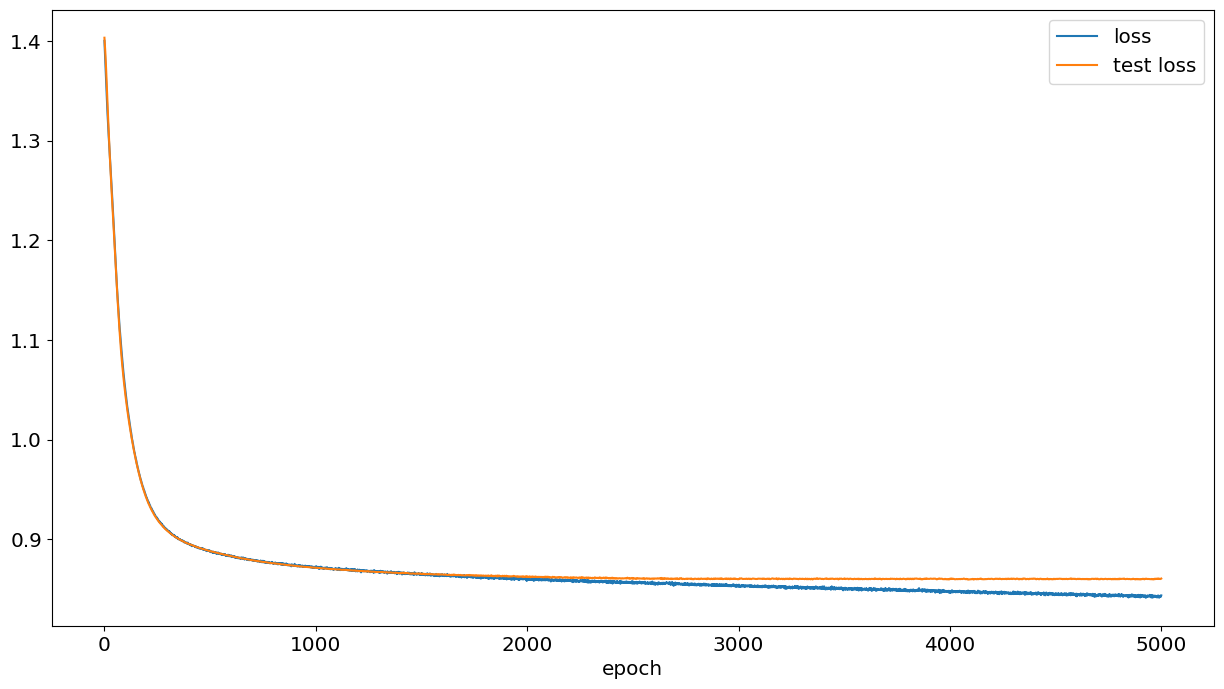

In [ ]:
loss_df.plot(x = 'epoch', y = ['loss', 'test loss']);

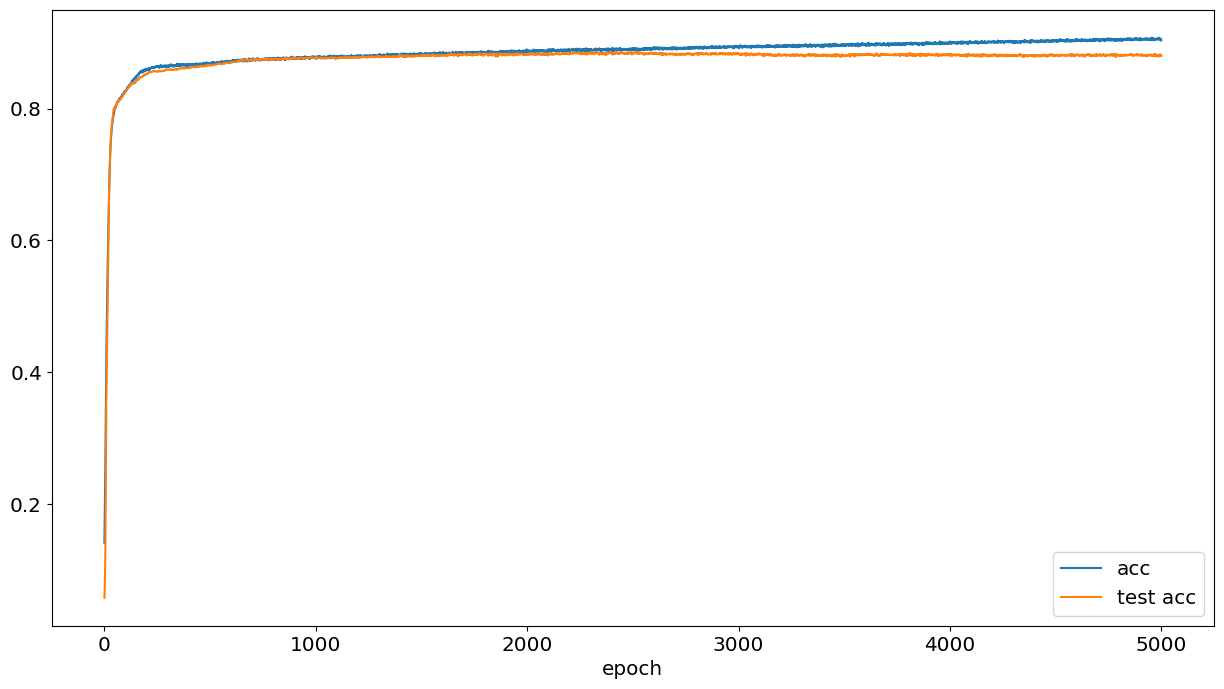

In [ ]:
loss_df.plot(x = 'epoch', y = ['acc', 'test acc']);

### Test Data

In [ ]:
pred_prob = model(test_X)
_, y_pred = torch.max(pred_prob, 1)
    
curr_acc_ts = accuracy_score(y_test.argmax(axis = 1), y_pred.data.cpu())

print(f'Accuracy score on Test Data : {curr_acc_ts: .4f}')

Accuracy score on Test Data :  0.8802


In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.92      1173
           2       0.83      0.86      0.85      1368
           3       0.84      0.76      0.80       684

    accuracy                           0.88      3630
   macro avg       0.90      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



In [ ]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[ 404,    0,    1,    0],
       [   0, 1094,   78,    1],
       [   0,   95, 1178,   95],
       [   0,    5,  160,  519]])

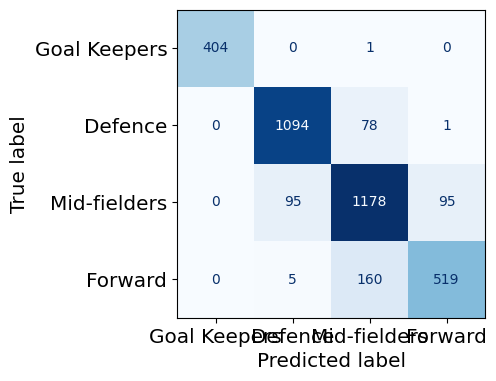

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();